In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pvlib
import datetime
import pprint
import os
import pySMARTS
from pathlib import Path


In [2]:
# Load the measured data
measured = pd.read_csv(os.path.join(os.path.join(Path().resolve(), 'Data','BARNirrad_measured.csv')), header = 1) # The field pyranometer data
srrl_weather = pd.read_csv(str(Path().resolve() / 'WeatherFiles' /  'PSM3_60T.csv'), header = 2) # Data from SRRL
# Create a Datetime variable and set it as the index
srrl_weather['date'] = srrl_weather[['Year','Month','Day']].astype(str).agg('-'.join, axis=1) # Couldn't think of a proper way to chain this process into a single command. If you think of something, please let me know
srrl_weather['Minute'] = 0
srrl_weather['time'] = srrl_weather[['Hour','Minute']].astype(str).agg(':'.join, axis=1)
srrl_weather['Datetime'] = pd.to_datetime(srrl_weather[['date','time']].agg(" ".join, axis=1))

srrl_weather.set_index('Datetime', inplace=True)
# Create a Datetime variable for the measured data using the existing 'TIMESTAMP' column.
measured['Datetime'] = pd.to_datetime(measured['TIMESTAMP'], format ='%m/%d/%Y %H:%M')
measured = measured.drop(["TIMESTAMP", "RECORD"], axis = 'columns') # drop this column so the resample command does not confuse TIMESTAMP and Datetime columns
measured = measured.set_index('Datetime').resample('60T', axis = 'index', label='right', closed='right').mean() # The "label" and the "closed" arguments are different from that of how the SRRL data was read-in (which was "right" for both arguments), but this somehow yields a better timing match.


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_13620\1807233682.py:14: FutureWarning: The 'axis' keyword in DataFrame.resample is deprecated and will be removed in a future version.
  measured = measured.set_index('Datetime').resample('60T', axis = 'index', label='right', closed='right').mean() # The "label" and the "closed" arguments are different from that of how the SRRL data was read-in (which was "right" for both arguments), but this somehow yields a better timing match.
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_13620\1807233682.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  measured = measured.set_index('Datetime').resample('60T', axis = 'index', label='right', closed='right').mean() # The "label" and the "closed" arguments are different from that of how the SRRL data was read-in (which was "right" for both arguments), but this somehow yields a better timing match.


In [27]:
vF = pd.read_csv('bifacialvF_sensors_specific.csv', header = 0) # The field pyranometer data
vF = vF.set_index(pd.to_datetime(vF['date']))
vF.index = vF.index.tz_localize(None)

In [32]:
len(measured)

1333

In [33]:
df = pd.concat([measured, srrl_weather, vF],axis=1, join="inner")
len(df)

640

In [35]:
# Finding calibration for AP_4
days = [g for n, g in df.groupby(pd.Grouper(freq='D'))]

plt.rcParams['figure.figsize'] = (12, 3)

val = []
for i in range (0, len(days)):
    data3 = days[i]
    if data3.GHI.max() >0:
        val.append(round(data3.Ap_4.max()/data3.GHI.max(),3))

In [36]:
val2 = [x for x in val if x > 1]
import statistics

correction_factor = statistics.mean(val2)

df['Ap_4_cal'] = df.Ap_4/correction_factor

In [38]:
df.keys()

Index(['Ap_1', 'Ap_2', 'Ap_3', 'Ap_4', 'Ap_5', 'ST_con', 'ST_pv_bp',
       'ST_pv_is', 'PAR_con', 'PAR_pv', 'Batt_Volt', 'PTemp_C', 'Year',
       'Month', 'Day', 'Hour', 'Wspd', 'Tdry', 'DHI', 'DNI', 'GHI', 'Albedo',
       'date', 'Minute', 'time', 'date', 'S1', 'S2', 'S3', 'S4', 'S5', 'sazm',
       'Ap_4_cal'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


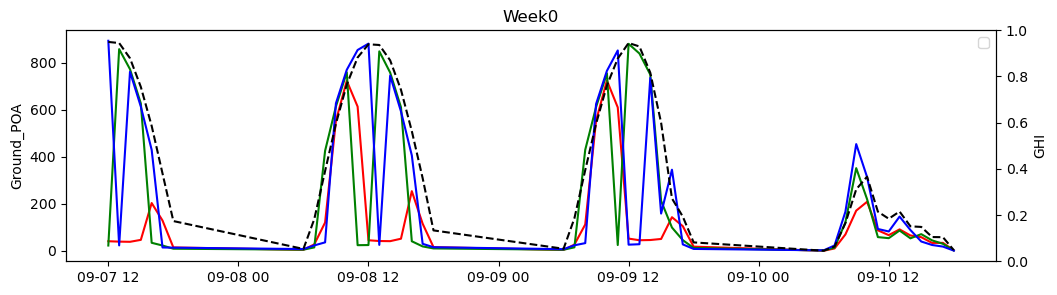

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


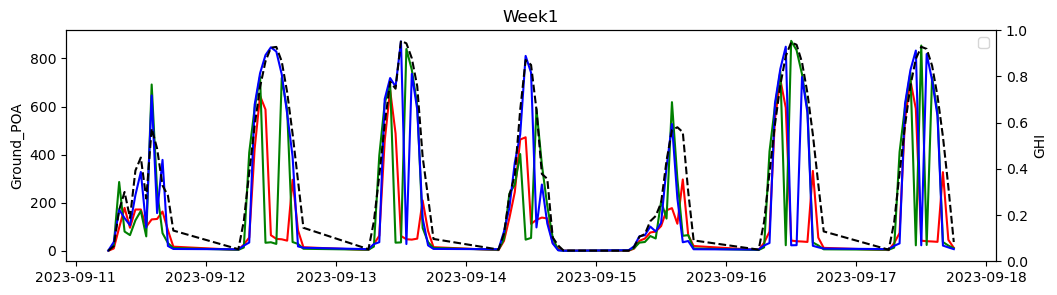

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


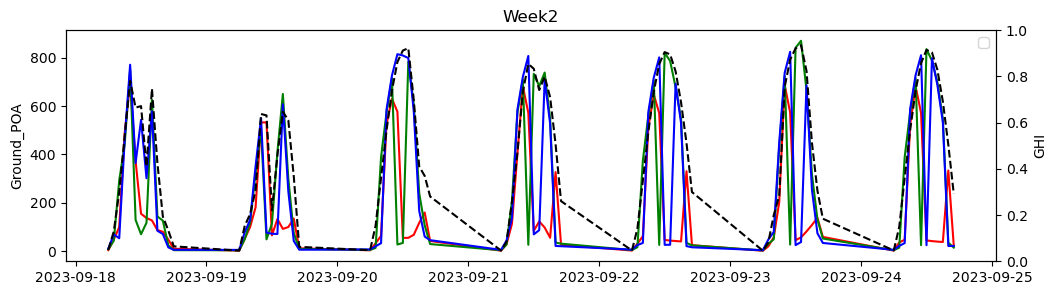

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


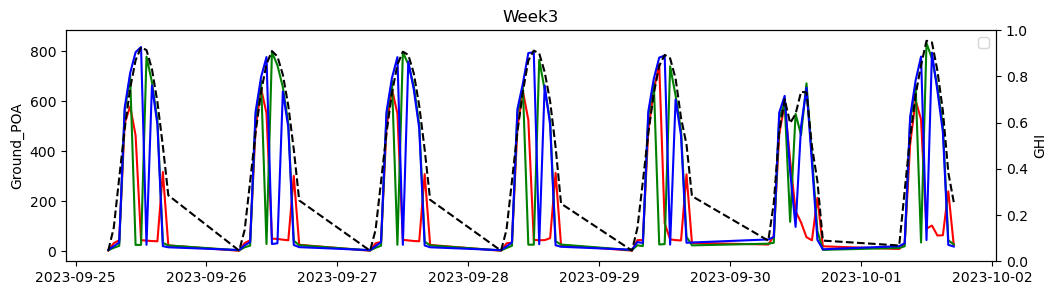

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


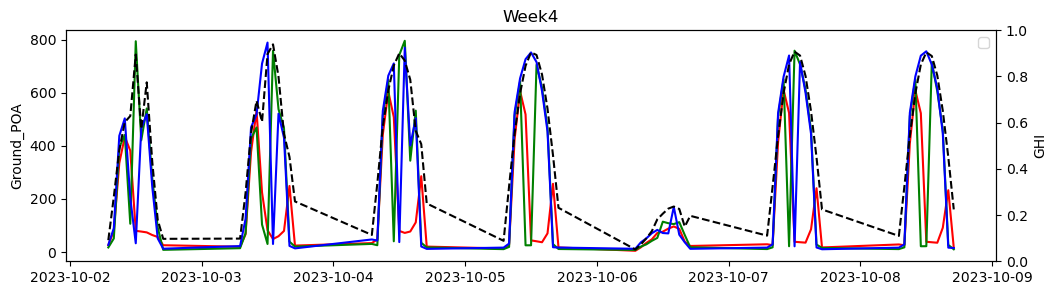

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


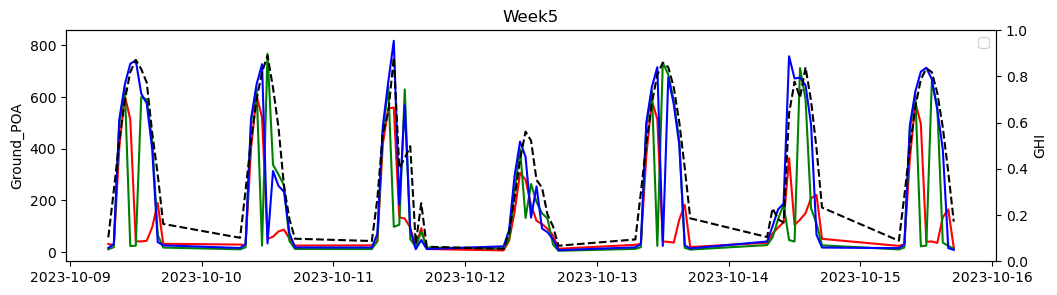

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


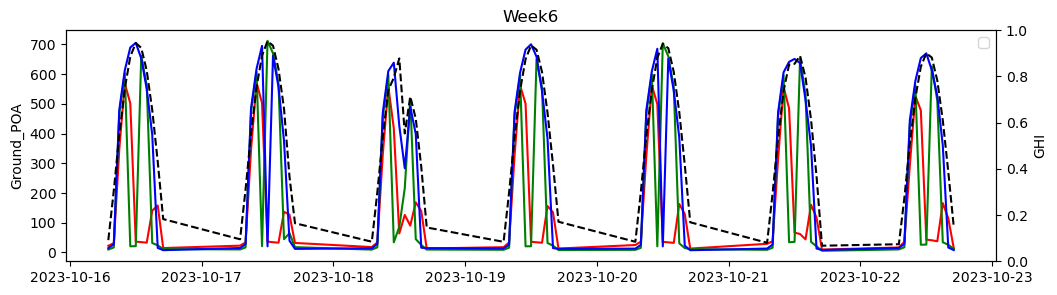

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


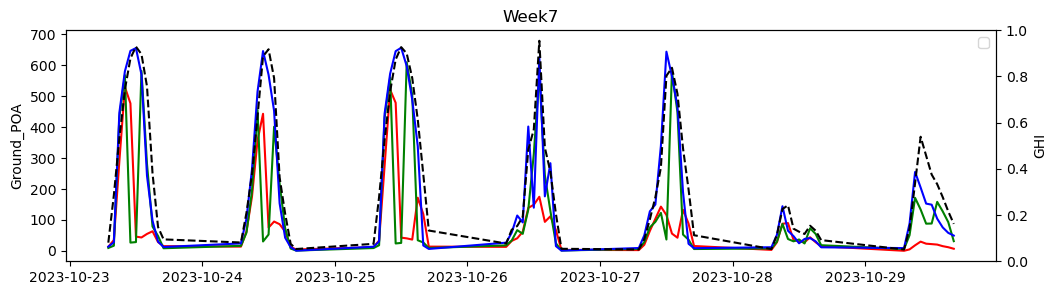

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


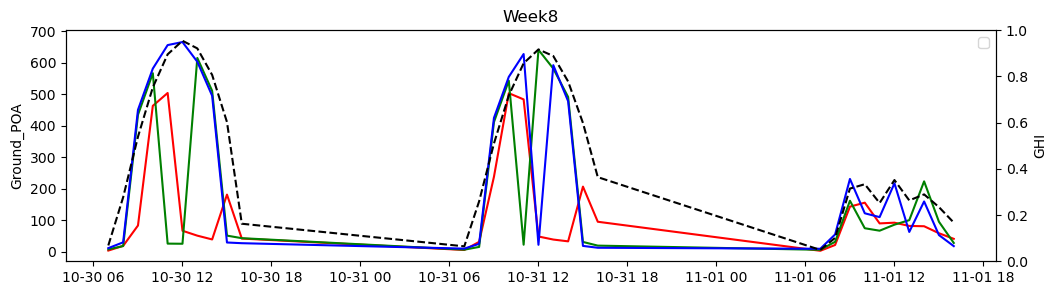

In [40]:
weeks = [g for n, g in df.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (12, 3)

for i in range (0, len(weeks)):
    fig, axs = plt.subplots(1,1)
    data3 = weeks[i]
    # Access each subplot using axs array
  
    plt.ylabel('Ground_POA')
    plt.plot(data3.index,data3.Ap_1, 'r', label='Sensor1')
    plt.plot(data3.index,data3.S1, 'g', label='Sensor2')
    plt.plot(data3.index,data3.S5, 'b', label='Sensor3')

    axs.twinx()
    axs.plot(data3.index,data3.GHI, '--k', label='GHI')
    plt.xticks(rotation = 45) 
    plt.title('Week'+str(i))
    plt.legend()    
    plt.ylabel('GHI')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


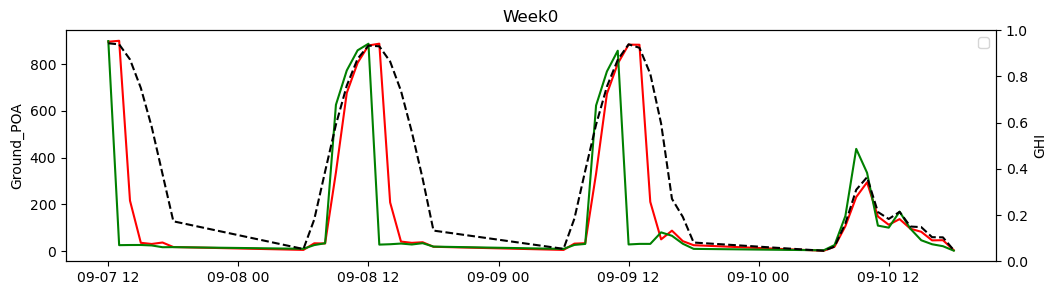

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


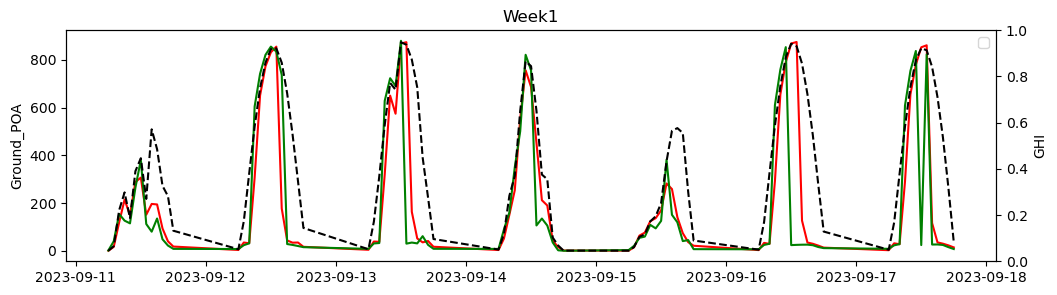

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


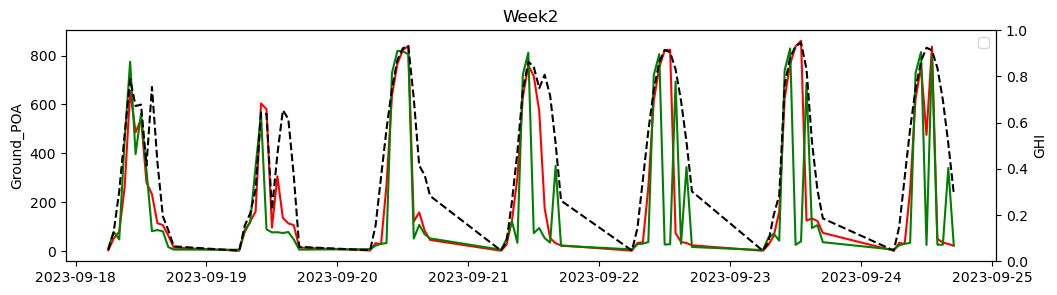

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


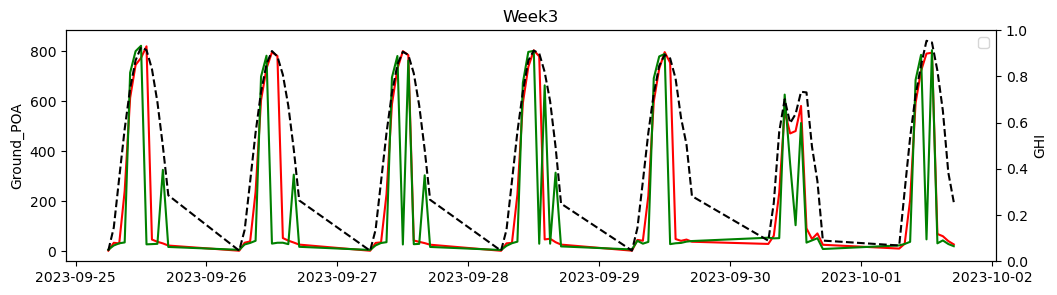

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


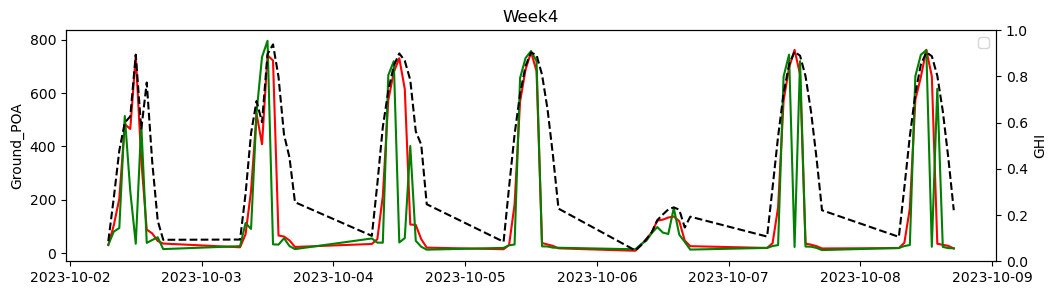

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


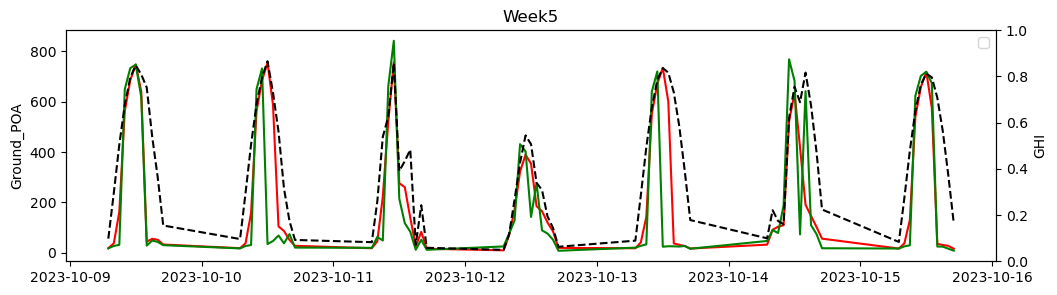

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


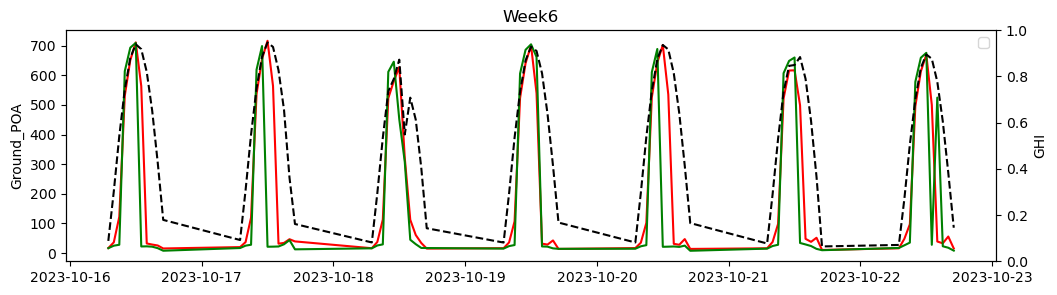

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


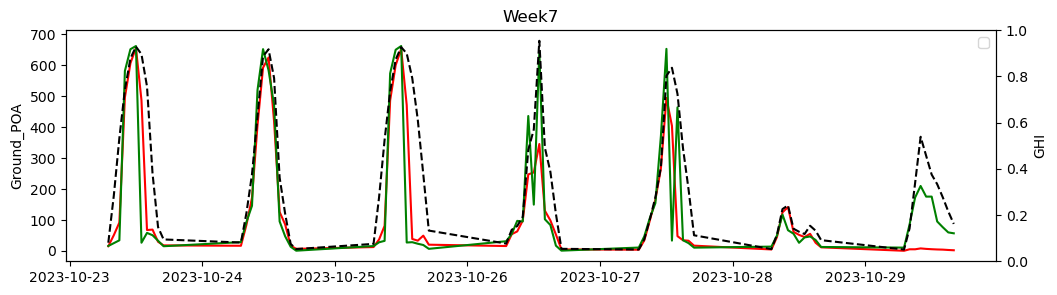

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


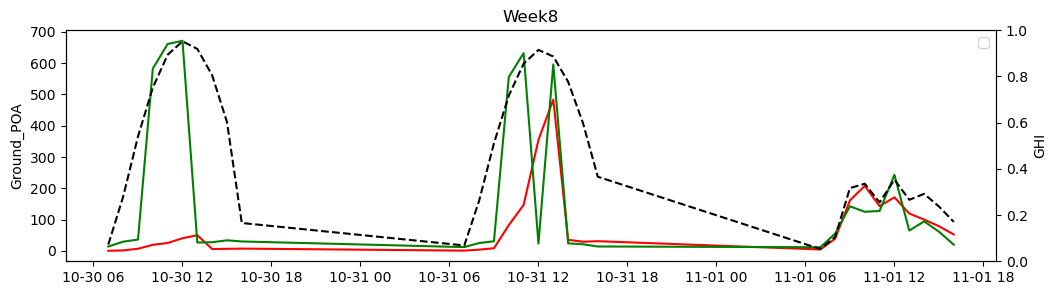

In [45]:
weeks = [g for n, g in df.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (12, 3)

for i in range (0, len(weeks)):
    fig, axs = plt.subplots(1,1)
    data3 = weeks[i]
    # Access each subplot using axs array
  
    plt.ylabel('Ground_POA')
    plt.plot(data3.index,data3.Ap_2, 'r', label='Sensor1')
    plt.plot(data3.index,data3.S4, 'g', label='Sensor2')

    axs.twinx()
    axs.plot(data3.index,data3.GHI, '--k', label='GHI')
    plt.xticks(rotation = 45) 
    plt.title('Week'+str(i))
    plt.legend()    
    plt.ylabel('GHI')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


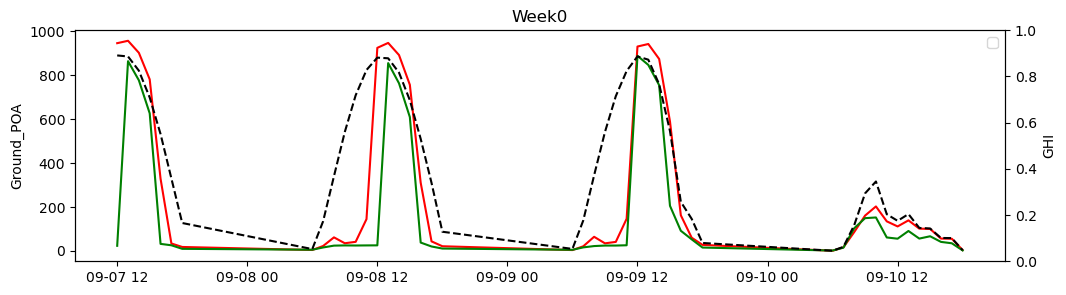

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


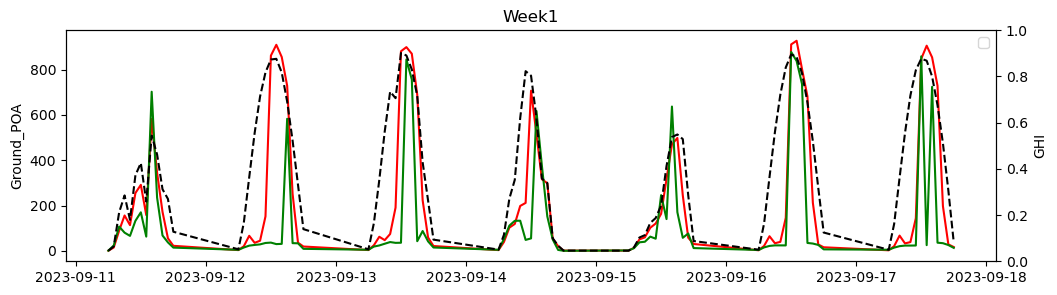

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


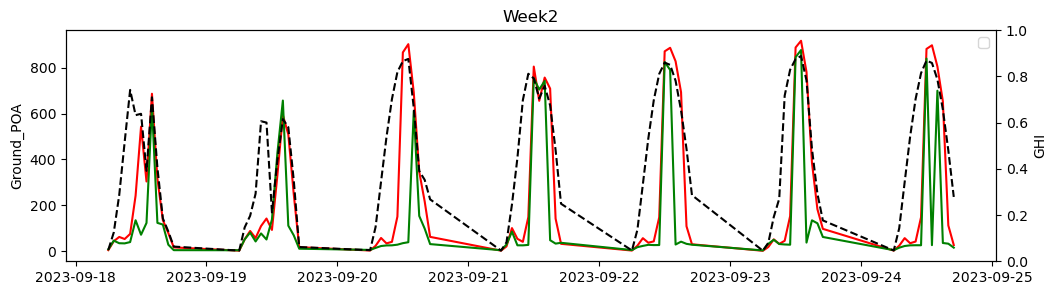

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


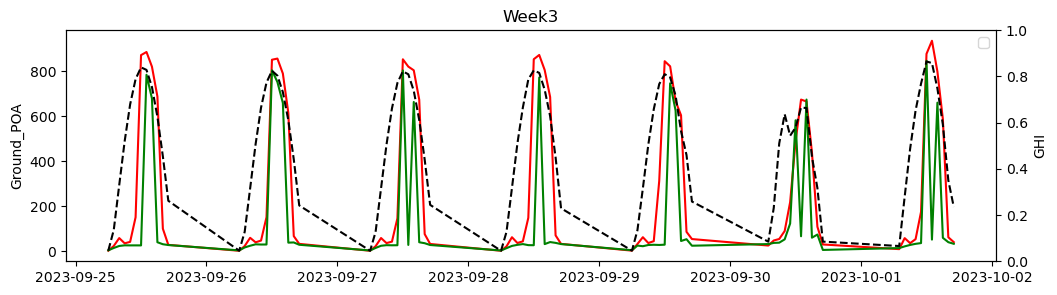

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


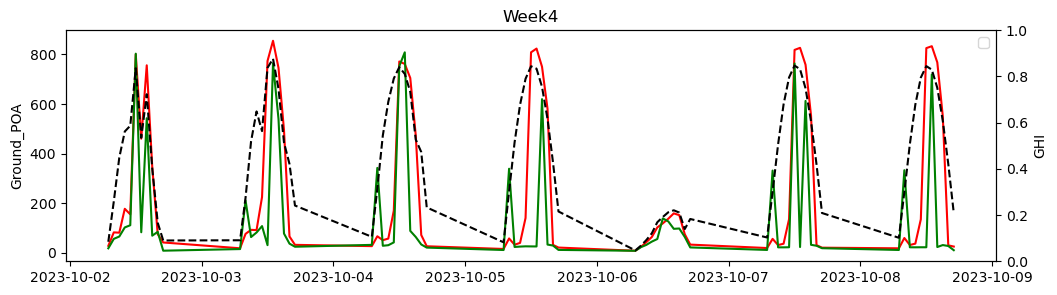

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


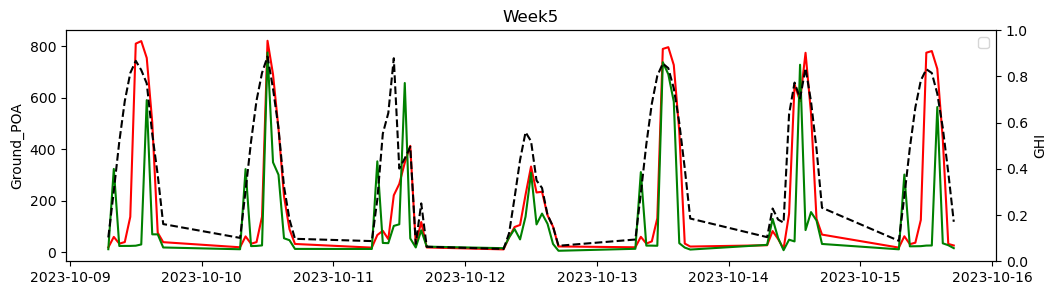

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


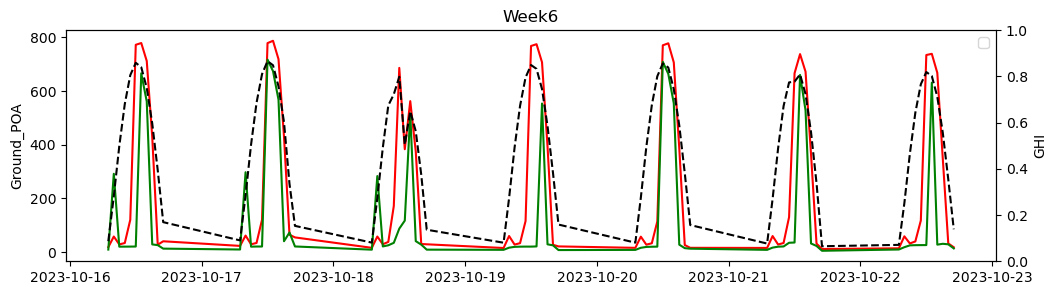

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


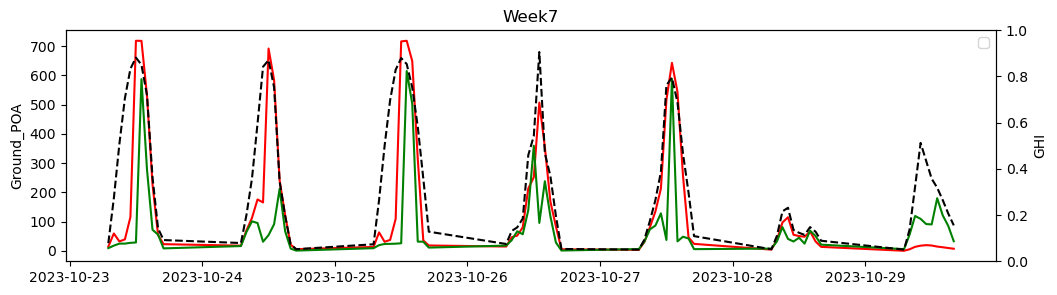

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


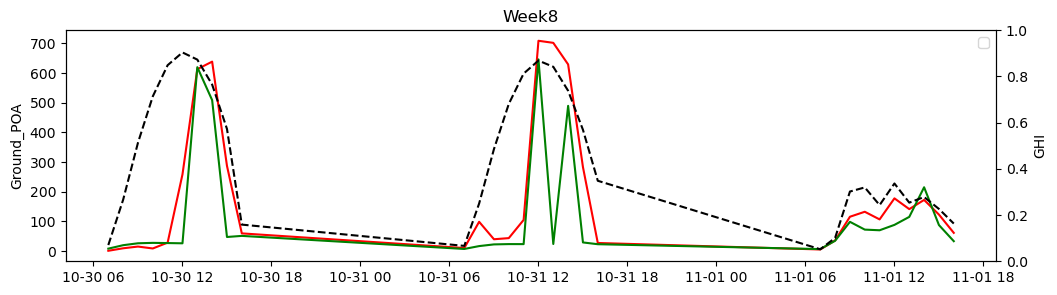

In [44]:
weeks = [g for n, g in df.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (12, 3)

for i in range (0, len(weeks)):
    fig, axs = plt.subplots(1,1)
    data3 = weeks[i]
    # Access each subplot using axs array
  
    plt.ylabel('Ground_POA')
    plt.plot(data3.index,data3.Ap_4, 'r', label='Sensor1')
    plt.plot(data3.index,data3.S2, 'g', label='Sensor2')

    axs.twinx()
    axs.plot(data3.index,data3.GHI, '--k', label='GHI')
    plt.xticks(rotation = 45) 
    plt.title('Week'+str(i))
    plt.legend()    
    plt.ylabel('GHI')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


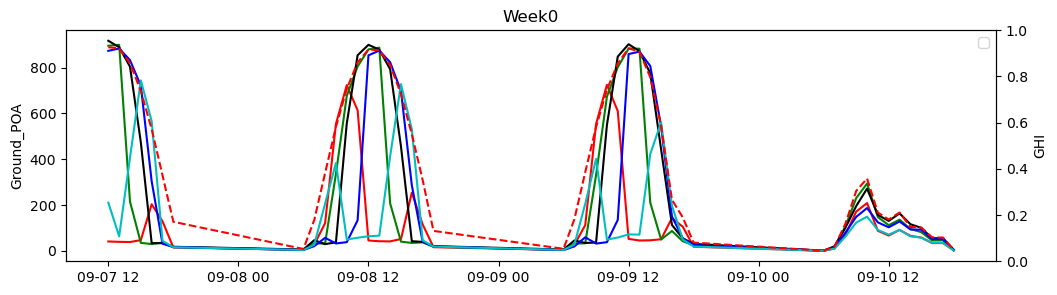

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


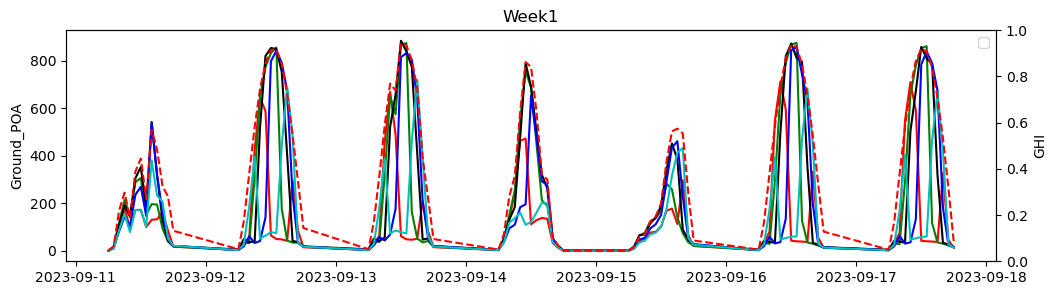

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


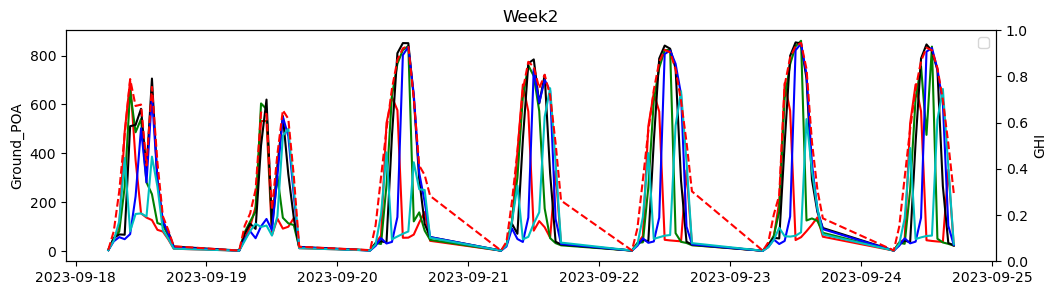

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


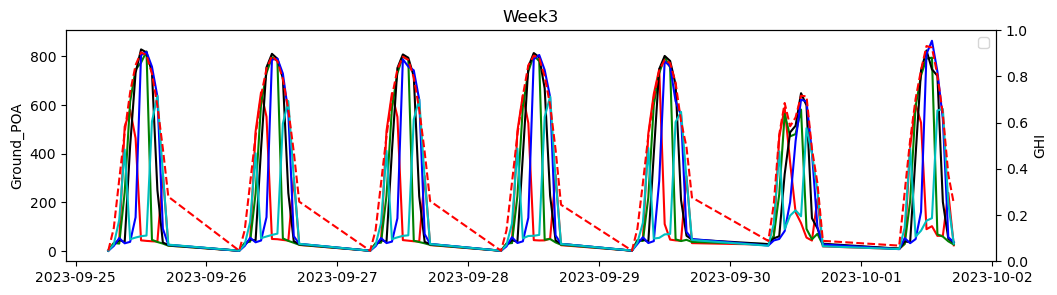

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


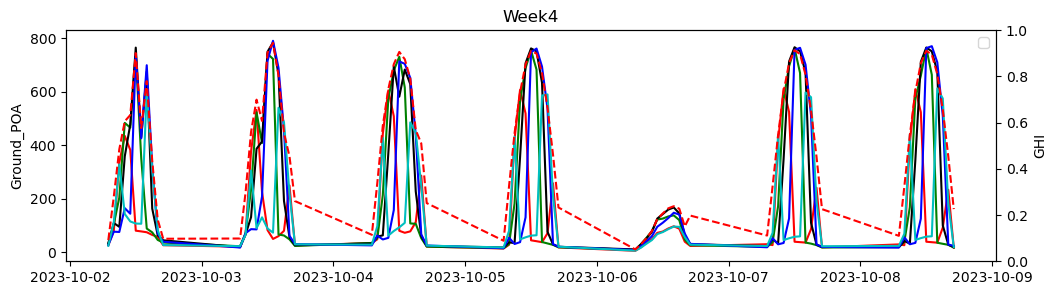

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


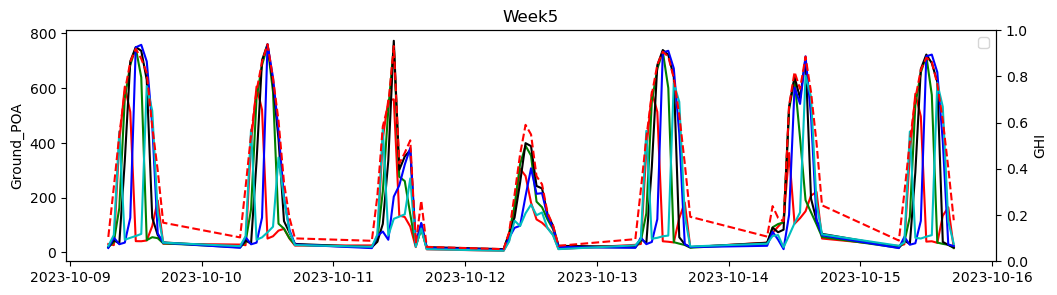

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


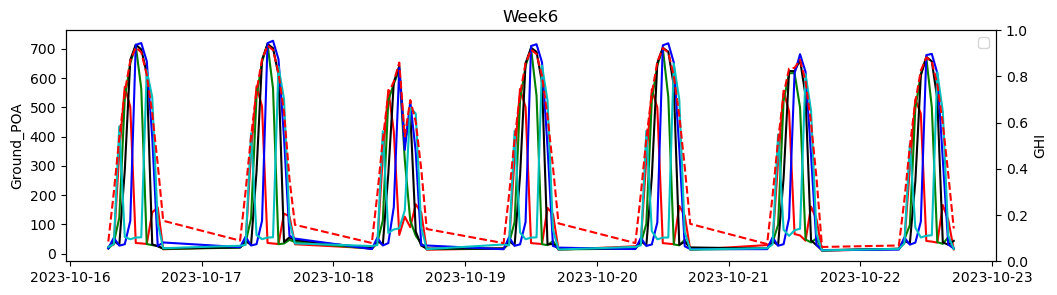

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


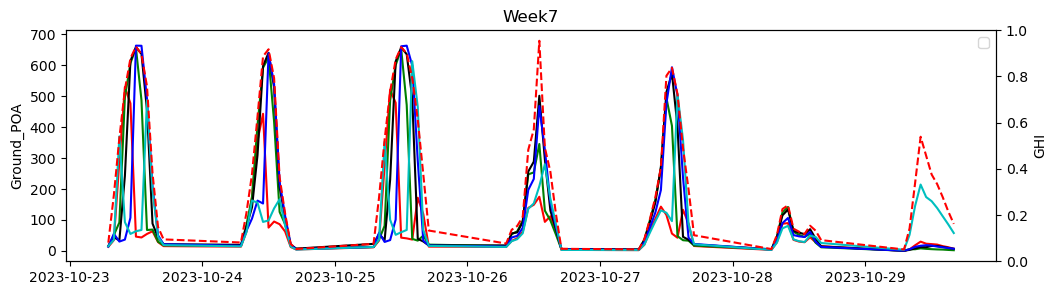

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


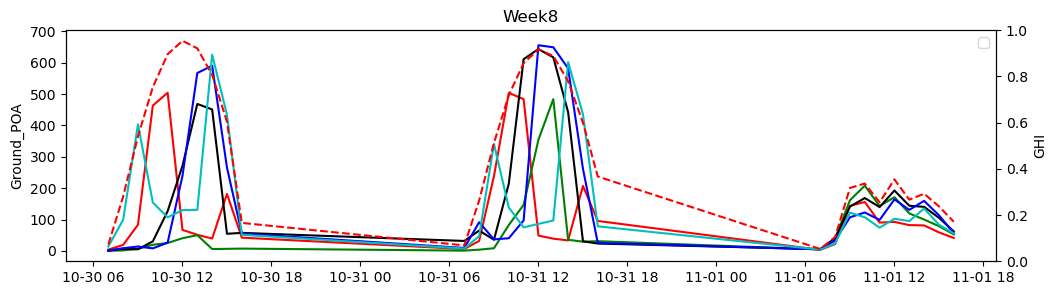

In [37]:
weeks = [g for n, g in df.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (12, 3)

for i in range (0, len(weeks)):
    fig, axs = plt.subplots(1,1)
    data3 = weeks[i]
    # Access each subplot using axs array
  
    plt.ylabel('Ground_POA')
    plt.plot(data3.index,data3.Ap_1, 'r', label='Sensor1')
    plt.plot(data3.index,data3.Ap_2, 'g', label='Sensor2')
    plt.plot(data3.index,data3.Ap_3, 'k', label='Sensor3')
    plt.plot(data3.index,data3.Ap_4_cal, 'b', label='Sensor4')
    plt.plot(data3.index,data3.Ap_5, 'c', label='Sensor5')

    axs.twinx()
    axs.plot(data3.index,data3.GHI, '--r', label='GHI')
    plt.xticks(rotation = 45) 
    plt.title('Week'+str(i))
    plt.legend()    
    plt.ylabel('GHI')
    plt.show()


In [ ]:
pySMARTS.__version__

In [ ]:
pwd

In [ ]:
from scipy import integrate


In [ ]:
df['spec_dni']=''
df['spec_dhi']=''
df['spec_ghi']=''
df['PAR_SMARTS'] = ''
df['SMARTS_DNI'] = ''
df['SMARTS_DHI'] = ''
df['SMARTS_GHI'] = ''

In [ ]:
#spec_dni = []
#spec_dhi = []
#spec_ghi = []

IOUT = '2 3 4' 
YEAR = '2023'
    
for ii in range (0, len(df)):
    if df.iloc[ii].GHI > 100: 
        MONTH = str(df.iloc[ii].Month).zfill(2)
        DAY = str(df.iloc[ii].Day).zfill(2)
        HOUR = str(df.iloc[ii].Hour).zfill(2)
        LATIT = '39.7407'
        LONGIT = '-105.1686'
        ALTIT = '1.730' # km above sea level
        ZONE = '-7' # Timezone
        spectra = pySMARTS.SMARTSTimeLocation(IOUT=IOUT,YEAR=YEAR,MONTH=MONTH,DAY=DAY,HOUR=HOUR, LATIT=LATIT, LONGIT=LONGIT, ALTIT=ALTIT, ZONE=ZONE)
        df['spec_dni'].iloc[ii]= list(spectra.Direct_normal_irradiance)
        df['spec_dhi'].iloc[ii]= list(spectra.Difuse_horizn_irradiance)
        df['spec_ghi'].iloc[ii]= list(spectra.Global_horizn_irradiance)
        df['PAR_SMARTS'].iloc[ii] = np.round(spectra.loc[240:540].Global_horizn_irradiance.sum(),3)
        df['SMARTS_DNI'].iloc[ii] = integrate.trapezoid(spectra.Direct_normal_irradiance, x=spectra.Wvlgth)
        df['SMARTS_DHI'].iloc[ii] = integrate.trapezoid(spectra.Difuse_horizn_irradiance, x=spectra.Wvlgth)
        df['SMARTS_GHI'].iloc[ii] = integrate.trapezoid(spectra.Global_horizn_irradiance, x=spectra.Wvlgth)

In [ ]:
df.to_csv('Intermediate_results.csv')

In [ ]:
pwd

In [ ]:
weeks = [g for n, g in df.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (12, 3)
fig, axs = plt.subplots(1,5)

for i in range (4, 5): #len(days)):
    data3 = days[i]
    # Access each subplot using axs array
    axs[0].plot(data3.index,data3.Ap_1, 'k', label='Sensor1')
    axs[1].plot(data3.index,data3.DNI, label='DNI')
    
#    plt.plot(data3.index,data3.Ap_1, 'k', label='Sensor1')
 #   plt.plot(data3.index,data3.DNI, label='DNI')

    plt.legend()
    plt.xticks(rotation = 45) 
    plt.ylabel('G_POA')
    plt.title('Day'+str(i))
    plt.show()


In [ ]:
startdate = '2021-09-07 7:0:0'
enddate = '2021-03-03 18:0:0'
foo = df[(df.index>startdate) & (df.index<enddate)]
plt.figure()
plt.plot(foo.index, foo.pvlib_Gfront, 'k', label='PVLIB')
plt.xticks(rotation=45)
titlestr = ptitle + ' ' + ' max angle ' + str(max_angle) + ' gcr ' + str(gcr)
plt.title(titlestr)

In [ ]:

# Add suffix to the columns in the measured dataframe before concatenating it with the modeled dataframe
measured_suffix = measured.add_suffix(".measured")
measured["datatype"]="measured"

modeledandmeasured_suffix = pd.concat([modeled_suffix, measured_suffix], axis=1, join='inner')
modeledandmeasured_melt = pd.wide_to_long(df = modeledandmeasured_suffix.reset_index(), stubnames= ["Ap_1", "Ap_2", "Ap_3", "Ap_4", "Ap_5","ST_con", "ST_pv_bp", "ST_pv_is", "PAR_con", "PAR_pv", "Batt_Volt", "PTemp_C"], i = "Datetime", j = "datatype", sep = ".", suffix = "\D+").reset_index().set_index('Datetime')

modeledandmeasured_melt2 = modeledandmeasured_melt[['datatype', 'Ap_1', 'Ap_2', 'Ap_3', 'Ap_4', 'Ap_5']].reset_index().melt(id_vars = ['Datetime', 'datatype'], var_name = 'position', value_name= 'value').reset_index()
modeledandmeasured_melt3 = modeledandmeasured_melt2.pivot(index=['Datetime', 'position'], columns = 'datatype', values = 'value')


# Sum up the irradiance values and divide it by 4 to get accumulated daily radiation
modeledandmeasured_sum = modeledandmeasured_melt2.reset_index().groupby(['position', 'datatype']).agg({"value":"sum"})['value'].transform(lambda x:x/4)

# Grab just the measured
ghipar = modeledandmeasured_melt.loc[modeledandmeasured_melt['datatype']=='measured'][['Ap_3', 'PAR_pv', 'PAR_con']]
srrlandghipar = pd.concat([ghipar, srrl_weather], axis=1, join="inner")[['Ap_3','GHI', 'PAR_pv', 'PAR_con']].rename(columns={'Ap_3':'ghi_pv','GHI':'ghi_con','PAR_pv':'par_pv','PAR_con':'par_con'}).reset_index()
srrlandghipar = pd.wide_to_long(df = srrlandghipar.reset_index(), stubnames=['ghi','par'], i = "Datetime", j = "location", sep = "_", suffix = "\D+").reset_index()
print(srrlandghipar)


In [ ]:
# # Tidy the data
# modeled_melt = resultsdf.melt(id_vars = ['Datetime'], var_name = 'position', value_name = 'value')
# modeled_melt['datatype'] = 'modeled'

# # Load the measured data
# measured = pd.read_csv(os.path.join(os.path.join(Path().resolve(), 'Data','BARNirrad_measured.csv')), header = 1)
# # print(resultsdf_melt.info)
# # measured.info

# measured['Datetime'] = pd.to_datetime(measured['TIMESTAMP'], format ='%m/%d/%Y %H:%M')
# measured = measured.drop(['TIMESTAMP'], axis='columns').set_index('Datetime')
# measured_15Tmean = measured.resample('15T', axis = 'index', label='right', closed='right').mean()
# # measured_select = measured[['Datetime', 'Ap_1', 'Ap_2', 'Ap_3', 'Ap_4', 'Ap_5']]
# measured_melt = measured.reset_index()[['Datetime', 'Ap_1', 'Ap_2', 'Ap_3', 'Ap_4', 'Ap_5']].melt(
#     id_vars = ['Datetime'],
#     var_name = 'position', 
#     value_name = 'value')
# measured_melt['datatype'] = 'measured'

# # combined = pd.merge(resultsdf_melt, measured_melt, how = 'left', on = 'Datetime')
# measured_melt = pd.merge(modeled_melt[['Datetime']], measured_melt, how = 'left', on = 'Datetime')
# measured_melt.drop_duplicates(inplace=True)
# combined = pd.concat([modeled_melt, measured_melt])


# # Make wider for another plot
# # combined_wider = combined.pivot(index=['Datetime', 'position'], columns='datatype', values = 'value').reset_index().set_index('Datetime')
# combined_wider = combined.pivot(index=['Datetime', 'position'], columns='datatype', values = 'value').reset_index()
# # print(combined_wider)
# combined_wider['time'] = pd.to_datetime(combined_wider['Datetime'], format = '%H:%M')
# combined_wider = combined_wider.set_index("Datetime")
# # Sum up the irradiance values
# # combined_sum = combined.groupby(['position', 'datatype']).agg(np.sum())
# combined['totalrad'] = combined.groupby(['position', 'datatype'])['value'].transform(lambda x: x.sum() / 4)
# combined_summary = combined[['position','datatype','totalrad']].drop_duplicates()
# print(combined_summary)


In [ ]:
# look at residuals (MBD, RMSE) based on Grear, Gpoa and Gtotal_modeled. From B. Marion Solar Energy 2016
def MBD(meas,model):
    # MBD=100∙[((1⁄(m)∙∑〖(y_i-x_i)]÷[(1⁄(m)∙∑〖x_i]〗)〗)
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    # rudimentary filtering of modeled irradiance
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = 100*((1/m)*sum(df.model-df.meas))/df.meas.mean()
    return out

def RMSE(meas,model):
    #RMSD=100∙〖[(1⁄(m)∙∑▒(y_i-x_i )^2 )]〗^(1⁄2)÷[(1⁄(m)∙∑▒〖x_i]〗)
    import numpy as np
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = 100*np.sqrt(1/m*sum((df.model-df.meas)**2))/df.meas.mean()
    return out

# residuals absolute output (not %) 
def MBD_abs(meas,model):
    # MBD=100∙[((1⁄(m)∙∑〖(y_i-x_i)]÷[(1⁄(m)∙∑〖x_i]〗)〗)
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    # rudimentary filtering of modeled irradiance
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = ((1/m)*sum(df.model-df.meas))
    return out

def RMSE_abs(meas,model):
    #RMSD=100∙〖[(1⁄(m)∙∑▒(y_i-x_i )^2 )]〗^(1⁄2)÷[(1⁄(m)∙∑▒〖x_i]〗)
    import numpy as np
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = np.sqrt(1/m*sum((df.model-df.meas)**2))
    return out

In [ ]:
# Create the empty arrays (or lists? I don't know all the object types in python) to save the result of the looped error analysis
MBD_result = []
RMSE_result = []
MBD_abs_result = []
RMSE_abs_result = []
faillist = []

# Grab the list of column names
colnames = list(modeledandmeasured_suffix.columns.values)
modposition = []
measposition = []

# Setting the index to 0 prior to running the for-loop
i = 0

# For-looping the error analyses
for i in range (0, 5): # The index range was determined after looking at the 
    try:
        MBD_result.append(MBD(modeledandmeasured_suffix[colnames[i+5]], modeledandmeasured_suffix[colnames[i]])) # The modeled columns and the measured counterparts are five columns apart, hence "i" and "i+5"
        RMSE_result.append(RMSE(modeledandmeasured_suffix[colnames[i+5]], modeledandmeasured_suffix[colnames[i]]))
        MBD_abs_result.append(MBD_abs(modeledandmeasured_suffix[colnames[i+5]], modeledandmeasured_suffix[colnames[i]]))
        RMSE_abs_result.append(RMSE_abs(modeledandmeasured_suffix[colnames[i+5]], modeledandmeasured_suffix[colnames[i]]))

        modposition.append(colnames[i])
        measposition.append(colnames[i+5])
    except:
        print(" FAILED ", i, colnames[i])
        faillist.append(colnames[i])

# Join the arrays into a dataframe
validationdf = pd.DataFrame(list(zip(modposition, measposition, MBD_result, RMSE_result, MBD_abs_result, RMSE_abs_result)), columns = ['Modeled', 'Measured', 'MBD', 'RMSE', 'MBD_abs', 'RMSE_abs'])    

# Export the result into a csv
validationdf.to_csv('out6.csv',index=False)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

## The following figures are best displayed in wide-screen.

In [ ]:
# Set the size for each figure, in pixels
figwidth = 1000
figheight = 400

# Simple line graph of the measured vs modeled irradiance values
fig1 = px.line(modeledandmeasured_melt2, x = 'Datetime', y = 'value', color = 'datatype', facet_col = 'position', facet_col_wrap = 5, width = figwidth, height = figheight)
fig1.update_layout(
    plot_bgcolor='white',
    xaxis_title = "",
    yaxis_title = "15-min average irradiance (W/m<sup>2</sup>)",
    legend=dict(
        yanchor="top",
        y=1.2,
        xanchor="center",
        x=0.5
    ),
    legend_title=dict(
        text = "Data type"
    ),
    legend_orientation="h"
)
fig1.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title = " "
)
fig1.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
# for axis in fig1.layout:
#    if axis.startswith("xaxis"):
#       fig1.layout[axis].title = ""
fig1.show()

rsqval = []
# 1-to-1 plot of the measured vs modeled irradiance values
fig2 = px.scatter(modeledandmeasured_melt3.reset_index(), x = 'measured', y = 'modeled', facet_col = 'position', facet_col_wrap=5, trendline="ols", trendline_color_override="black", width = figwidth, height = figheight)
    # Accessing the R-squared values and annotating each facet
for i in range(len(np.unique(modeledandmeasured_melt3.reset_index()['position']))): #'position' can be replaced with whatever column is being used for the facets
    # Accessing R-squared value
    rsqval=round(px.get_trendline_results(fig2).iloc[i]["px_fit_results"].rsquared, 4)

    # Annotating each facet with the R-squared value
    fig2.add_annotation(
        xref='paper', yref='paper',
        x=10, y=800,
        xanchor='left', yanchor='bottom',
        text=f'R<sup>2</sup>: {rsqval:.4f}',
        showarrow=False,
        font=dict(size=12),
        row= 1, col=i+1 # only works when the facets are in a single row
    )

fig2.update_layout(
    plot_bgcolor='white',
    xaxis_title = "Measured irradiance (W/m<sup>2</sup>)",
    yaxis_title = "Modeled irradiance (W/m<sup>2</sup>)"
)
fig2.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig2.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig2.update_traces(marker=dict(size=6,
                                color='rgba(135, 206, 250, 0.5)',
                                line=dict(width=2,
                                    color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig2.show()

# side-by-side barcharts
fig3 = px.bar(modeledandmeasured_sum.reset_index(), x='position', y='value', color='datatype', barmode='group', width = figwidth, height = figheight)
fig3.update_layout(
    plot_bgcolor='white',
    xaxis_title = "",
    yaxis_title = "Daily total radiation (Wh/m<sup>2</sup>)",
    legend=dict(
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=0.01
    ),
    legend_title=dict(
        text = "Data type"
    ),
    legend_orientation="h"
)
fig3.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig3.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig3.show()

# GHI vs PAR inside an array vs 
fig4 = px.scatter(srrlandghipar, x = 'ghi', y = 'par', color = 'location', trendline="ols",color_discrete_sequence=px.colors.qualitative.Antique, width = figwidth, height = figheight)

fig4.update_layout(
    legend=dict(
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=0.01
        ),
    legend_title=dict(
        text = "Location"
        ),
    legend_orientation="h",
    plot_bgcolor='white',
    yaxis_title = "Measured photoactive radiation (umol m<sup>-2</sup> s<sup>-1</sup>)",
    xaxis_title = "Measured global horizontal irradiance (W/m<sup>2</sup>)"
)
fig4.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig4.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig4.update_traces(marker=dict(size=6,
                                # color='rgba(135, 206, 250, 0.5)',
                                line=dict(width=2,
                                    color='DarkSlateGrey')),
                  selector=dict(mode='markers'))


## Stitch all the figures into a single HTML
Function below taken from https://stackoverflow.com/questions/45577255/plot-multiple-figures-as-subplots

In [ ]:
def figures_to_html(figs, filename="dashboard.html"):
    with open(filename, 'w') as dashboard:
        dashboard.write("<html><head></head><body>" + "\n")
        for fig in figs:
            inner_html = fig.to_html().split('<body>')[1].split('</body>')[0]
            dashboard.write(inner_html)
        dashboard.write("</body></html>" + "\n")


figures_to_html([fig1, fig2, fig3, fig4], 'BARN_validation.html')

In [ ]:
type(fig1.layout)

Next steps:<br>
Divide the data by AM and PM and <br>
Implement 15-minute averaging to the data: dataframe.resample(freq='15T', label='right', closed='right').mean() <br>
Keep the data in wide form to avoid repeating indices <br>
Look for the script MBD_RMSE_functions.py and perform error analysis to annotatet the scatterplot (also ) <br>
Plot Irradiance sensor 3 vs PAR sensor (for within row and in control (GHI from SRRL)) and use the time of the day as a gradient and point shape as the data type <br>
Superimpose some of the figures with a side-view of an agrivoltaics row